In [1]:
import networkx as nx
import numpy as np
import functools
import random

In [2]:
from optiLib.problem import NetGraph
from optiLib.problem import TaskGraph

def generate_adjacency_matrix(rows, cols):
    num_nodes = rows * cols
    adjacency_matrix = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]

    for row in range(rows):
        for col in range(cols):
            node_index = row * cols + col
            if col > 0:  # узел слева
                adjacency_matrix[node_index][node_index - 1] = 1
            if col < cols - 1:  # узел справа
                adjacency_matrix[node_index][node_index + 1] = 1
            if row > 0:  # узел сверху
                adjacency_matrix[node_index][node_index - cols] = 1
            if row < rows - 1:  # узел снизу
                adjacency_matrix[node_index][node_index + cols] = 1

    return adjacency_matrix


martx = [
    [0, 100, 100, 0], 
    [0, 0, 0, 100], 
    [0, 0, 0, 100], 
    [0, 0, 0, 0], 
]

net  = NetGraph(generate_adjacency_matrix(3, 3), net_power=(1000, 2500), net_power_arr=[5000, 500, 2000, 1000, 3000, 2000, 300, 1500, 1000], e0=(10, 50), emax=(70,100))
task = TaskGraph(martx, w_arr=[10000, 5000, 5000, 3000])

In [3]:
import functools
import networkx as nx
import numpy as np

@functools.lru_cache
def create_paths(vector, task_edges, network_graph):
    RANDOM_SEED = 1
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    paths = {}
    
    for start, end in task_edges:
        if vector[start] == vector[end]:
            paths[str(start) + str(end)] = [vector[start]]
        else:
            paths[str(start) + str(end)] = random.choice(list(nx.all_shortest_paths(network_graph, vector[start], vector[end])))
    return paths

@functools.lru_cache
def network_status_calculation(vector, problem):
    RANDOM_SEED = 1
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    
    T_lim = problem.t_lim
    vector_tuple = tuple(vector) 
    task_edges = tuple((start, end) for start, end, _ in nx.to_edgelist(problem.task_graph.graph))
    network_graph = problem.network_graph.graph
    
    paths = create_paths(vector_tuple, task_edges, network_graph)
    
    net_number = network_graph.number_of_nodes()
    task_number = problem.task_graph.graph.number_of_nodes()

    W = [0] * net_number
    v_task_to_node = [0] * net_number
    v_sent_to_node = [0] * net_number
    v_reseive_to_node = [0] * net_number
    
    for start, end, weight in nx.to_edgelist(problem.task_graph.graph):
        path_key = str(start) + str(end)
        path = paths[path_key]
        
        if len(path) > 1:
            W[path[0]] += problem.task_graph.operations[start].w + weight['weight']
            v_sent_to_node[path[0]] += weight['weight']
            v_task_to_node[path[0]] += problem.task_graph.operations[start].w
            
            W[path[-1]] += problem.task_graph.operations[end].w + weight['weight']
            v_reseive_to_node[path[-1]] += weight['weight']
            v_task_to_node[path[-1]] += problem.task_graph.operations[end].w
            
            for node in path[1:-1]:
                W[node] += 2 * weight['weight']
                v_sent_to_node[node] += weight['weight']
                v_reseive_to_node[node] += weight['weight']
        else:
            W[vector[start]] += problem.task_graph.operations[start].w
            v_task_to_node[vector[start]] += problem.task_graph.operations[start].w
            
            W[vector[end]] += problem.task_graph.operations[end].w
            v_task_to_node[vector[end]] += problem.task_graph.operations[end].w
    
    vector_tuple = tuple(vector) 
    
    arr = sorted(nx.all_simple_paths(problem.task_graph.graph, 0, task_number - 1), key=len, reverse=True)
    
    T_task = [0] * task_number
    len_first_path = len(arr[0])
    time_per_task = T_lim / len_first_path
    
    for task in arr[0]:
        T_task[task] = time_per_task
    
    for path_task in arr[1:]:
        sum_t = sum(T_task[task] for task in path_task)
        temp = [task for task in path_task if T_task[task] == 0]
        
        if temp:  # если нашлись задачи без оценки времени
            time_remaining = max(0, T_lim - sum_t)
            time_per_task_temp = time_remaining / len(temp)
            for task in temp:
                T_task[task] = time_per_task_temp
    
    T_NET = [0] * net_number

    for start, end, _ in nx.to_edgelist(problem.task_graph.graph):
        path_net = paths[str(start) + str(end)]
        if len(path_net) == 1:
            T_NET[path_net[-1]] = min(T_NET[path_net[-1]] or time_per_task, T_task[start], T_task[end])
        else:
            T_NET[path_net[-1]] = min(T_NET[path_net[-1]] or T_task[end], T_task[end])
            time_start_share = T_task[start] / (len(path_net) - 1)
            for node in path_net[:-1]:
                T_NET[node] = min(T_NET[node] or time_start_share, time_start_share)
    
    special_t = T_lim / len_first_path
    result = [[] for _ in range(net_number)]
    for i, val in enumerate(vector):
        result[val].append(i)
    
    for node in range(net_number):
        common_tasks = set(result[node]) & set(arr[0])
        if len(common_tasks) > 1:
            T_NET[node] = special_t * len(common_tasks)
    
    D = [W[i] / (problem.network_graph.nodes[i].p * T_NET[i]) if T_NET[i] != 0 else 0 for i in range(net_number)]
    return {"w":W, "v_task_to_node":v_task_to_node, "v_sent_to_node":v_sent_to_node, "v_reseive_to_node":v_reseive_to_node, "D":D, "T_NET":T_NET, "T_task":T_task}

@functools.lru_cache
def status(vector, problem):
    problem.scheduler.calculate_schedule(vector)
    return {"Time":problem.scheduler.get_total_execution_time(), "edge_hop":problem.scheduler.get_transfer_count(), "time_node":problem.scheduler.get_node_working_times()}

def c1_time_limit(vector, problem):
    """
    Проверка на ограничение по времени
    """
    net_ststus = status(tuple(vector), problem)
    time = net_ststus['Time']
    return int(time <= problem.t_lim)

def c2_restriction_first_node(vector, problem):
    """
    Проверка на ограничение на первый узел 
    """
    net_ststus = status(tuple(vector), problem)
    time_node = net_ststus['time_node']
    return int(time_node[0] <= 3)

def f1_min_hop(vector, problem):
    net_ststus = status(tuple(vector), problem)
    edge_hop = net_ststus['edge_hop']
    return edge_hop

def f_min_workload_node_0(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]

    node = 0
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload  


def f_min_workload_node_1(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 1
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_2(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 2
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_3(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 3
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_4(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 4
    workload = time_node.get(node, 0) / t 
    return 1 if workload == 0 else workload 

def f_min_workload_node_5(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 5
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_6(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 6
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_7(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 7
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f_min_workload_node_8(vector, problem):
    net_ststus = status(tuple(vector), problem)
    t = net_ststus["Time"]
    time_node = net_ststus["time_node"]
    node = 8
    workload = time_node.get(node, 0) / t
    return 1 if workload == 0 else workload 

def f2(vector, problem):
    """
    Вычисляет количество пересылок данных, необходимых при распределении задач
    по узлам сети, если изначально все задачи были на узле 0.
    
    Args:
        vector (list): Вектор распределения задач на узлы сети.
        problem (): network_graph (nx.Graph): Граф сети.
        
    Returns:
        int: Общее количество пересылок данных.
    """
    total_transfers = 0
    network_graph = problem.network_graph.graph

    for task_id, node_id in enumerate(vector):
        if node_id != 0:
            # Найти кратчайший путь от узла 0 до текущего узла
            path = nx.shortest_path(network_graph, source=0, target=node_id)
            
            # Увеличить счетчик пересылок на количество узлов в пути
            total_transfers += len(path) - 1
    
    return total_transfers + 1


In [4]:
from optiLib import NetworkOptimizationProblem

problem = NetworkOptimizationProblem(net, task, f_objective=[f1_min_hop, f_min_workload_node_0, f_min_workload_node_1, f_min_workload_node_2, f_min_workload_node_3, f_min_workload_node_4, f_min_workload_node_5, f_min_workload_node_6, f_min_workload_node_7, f_min_workload_node_8], f_constraints=[c1_time_limit, c2_restriction_first_node], t_lim=10, net_speed=5000, bounds={0: [0,0]}, name="NETproblem_3")

: 

In [ ]:
from IPython.display import clear_output

for exp in range(0, 2001):
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer, ParticleSwarmOptimizer

    # Инициализация оптимизатора
    optimizer = ParticleSwarmOptimizer(problem, inertia = 1.7,cognitive = 2.5 , social = 1.5, num_particles=100, iterations=1000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    print(len(optimizer.history))
    if len(optimizer.history)>0:
        optimizer.save(exp)
    
    clear_output(wait=True)

Эксперемент 207


Optimizing:   0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = RandomSearchOptimizer(problem, iterations=10000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)


Эксперемент 2000


Optimizing:   0%|          | 15/10000 [00:00<00:01, 5000.76it/s]

Лучшее решение: [0 4 5 4]
Значение целевой функции: 0.00037153098236336146


Данные сохранены в файл: ./data/NETproblem_3RS.xlsx


In [8]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import DirectedRandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = DirectedRandomSearchOptimizer(problem, iterations=10000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

Эксперемент 2000


Optimizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Лучшее решение: [0 7 5 7]
Значение целевой функции: 7.282591462867222e-06


Данные сохранены в файл: ./data/NETproblem_3DRS.xlsx


In [9]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import GeneticAlgorithm

    # Инициализация оптимизатора
    optimizer = GeneticAlgorithm(problem, population_size=100, generations=1000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

Эксперемент 2000


Оптимизация: 100%|██████████| 1000/1000 [00:01<00:00, 516.21it/s]


Лучшее решение: [0 3 8 5]
Значение целевой функции: 2.0145872347514017e-07
Данные сохранены в файл: ./data/NETproblem_3GA.xlsx


In [10]:
from optiLib import NetworkOptimizationProblem

problem = NetworkOptimizationProblem(net, task, f_objective=[f1_min_hop, f_min_workload_node_0, f_min_workload_node_1, f_min_workload_node_2, f_min_workload_node_3, f_min_workload_node_4, f_min_workload_node_5, f_min_workload_node_6, f_min_workload_node_7, f_min_workload_node_8], f_constraints=[c1_time_limit, c2_restriction_first_node], t_lim=15, net_speed=100, bounds={0: [0,0]}, name="NETproblem_4")

In [12]:
from IPython.display import clear_output

for exp in range(0, 2001):
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer, ParticleSwarmOptimizer

    # Инициализация оптимизатора
    optimizer = ParticleSwarmOptimizer(problem, inertia = 1.7,cognitive = 2.5 , social = 1.5, num_particles=100, iterations=1000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    print(len(optimizer.history))
    if len(optimizer.history)>0:
        optimizer.save(exp)
    
    clear_output(wait=True)

Эксперемент 2000


Optimizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Лучшее решение: [0 5 5 7]
Значение целевой функции: 2.7202281585960644e-06
1


Данные сохранены в файл: ./data/NETproblem_4PSO.xlsx


In [13]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = RandomSearchOptimizer(problem, iterations=10000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)


Эксперемент 2000


Optimizing:   0%|          | 5/10000 [00:00<00:01, 5003.94it/s]

Лучшее решение: [0 7 7 0]
Значение целевой функции: 0.005008116783904629


Данные сохранены в файл: ./data/NETproblem_4RS.xlsx


In [14]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import DirectedRandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = DirectedRandomSearchOptimizer(problem, iterations=10000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

Эксперемент 2000


Optimizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Лучшее решение: [0 7 5 7]
Значение целевой функции: 7.282591462867222e-06


Данные сохранены в файл: ./data/NETproblem_4DRS.xlsx


In [15]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import GeneticAlgorithm

    # Инициализация оптимизатора
    optimizer = GeneticAlgorithm(problem, population_size=100, generations=1000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

Эксперемент 2000


Оптимизация:   0%|          | 2/1000 [00:00<00:05, 190.12it/s]

Лучшее решение: [0 7 8 8]
Значение целевой функции: 1.8778836799035714e-09


Данные сохранены в файл: ./data/NETproblem_4GA.xlsx


In [16]:
0/0

ZeroDivisionError: division by zero

In [5]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer, ParticleSwarmOptimizer

    # Инициализация оптимизатора
    optimizer = ParticleSwarmOptimizer(problem, inertia = 1.7,cognitive = 2.5 , social = 1.5, num_particles=100, iterations=10000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)


Эксперемент 2000


Optimizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Лучшее решение: [0 2 3 7]
Значение целевой функции: 5.761399908565784e-05


Данные сохранены в файл: ./data/NETproblem_3PSO.xlsx


In [6]:
from IPython.display import clear_output

for exp in range(0, 2001):
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer, ParticleSwarmOptimizer

    # Инициализация оптимизатора
    optimizer = ParticleSwarmOptimizer(problem, inertia = 1.7,cognitive = 2.5 , social = 1.5, num_particles=100, iterations=1000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    print(len(optimizer.history))
    if len(optimizer.history)>0:
        optimizer.save(exp)
    
    clear_output(wait=True)

Эксперемент 2000


Optimizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Лучшее решение: [0 2 3 7]
Значение целевой функции: 5.761399908565784e-05
1


Данные сохранены в файл: ./data/NETproblem_3PSO.xlsx


In [7]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = RandomSearchOptimizer(problem, iterations=300000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)


Эксперемент 2000


Optimizing:   0%|          | 15/300000 [00:00<00:19, 15036.94it/s]

Лучшее решение: [0 4 5 4]
Значение целевой функции: 0.00037153098236336146


Данные сохранены в файл: ./data/NETproblem_3RS.xlsx


: 

In [6]:
from IPython.display import clear_output

for exp in range(0, 2001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import DirectedRandomSearchOptimizer

    # Инициализация оптимизатора
    optimizer = DirectedRandomSearchOptimizer(problem, iterations=20000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

Эксперемент 743


Optimizing:  83%|████████▎ | 16575/20000 [00:02<00:00, 7983.08it/s]

: 

In [ ]:
from IPython.display import clear_output

for exp in range(0, 10001):
    clear_output(wait=True)
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import GeneticAlgorithm

    # Инициализация оптимизатора
    optimizer = GeneticAlgorithm(problem, population_size=100, generations=1000, update_history_coef = 1000)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    if len(optimizer.history)>0:
        optimizer.save(exp)

Эксперемент 1249


Оптимизация:  13%|█▎        | 127/1000 [00:01<00:08, 104.15it/s]


Лучшее решение: [0 0 0 5 3 4 5 0 8 2 1 0 0]
Значение целевой функции: 2.5266222825529805e-05


In [8]:
print(optimizer.history)

[{'iteration': 5, 'Решение': 505, 'Алгоритм': 'PSO', 'vector': array([0, 0, 0, 8, 0, 0, 8, 0, 0, 0, 0, 0, 0])}]


In [7]:
problem.scheduler.calculate_schedule([0, 5, 5, 5])

In [8]:
problem.scheduler.print_extended_info()


Расширенная информация:
Общее время выполнения комплекса задач: 9.97

Время работы каждого узла:
Узел 0: 2.04
Узел 1: 0.80
Узел 2: 0.20
Узел 5: 6.60

Время, затраченное каждым узлом на отправку данных:
Узел 0: 0.04
Узел 1: 0.40
Узел 2: 0.10

Время, затраченное каждым узлом на прием данных:
Узел 1: 0.40
Узел 2: 0.10
Узел 5: 0.10

Общее количество пересылок между задачами: 6


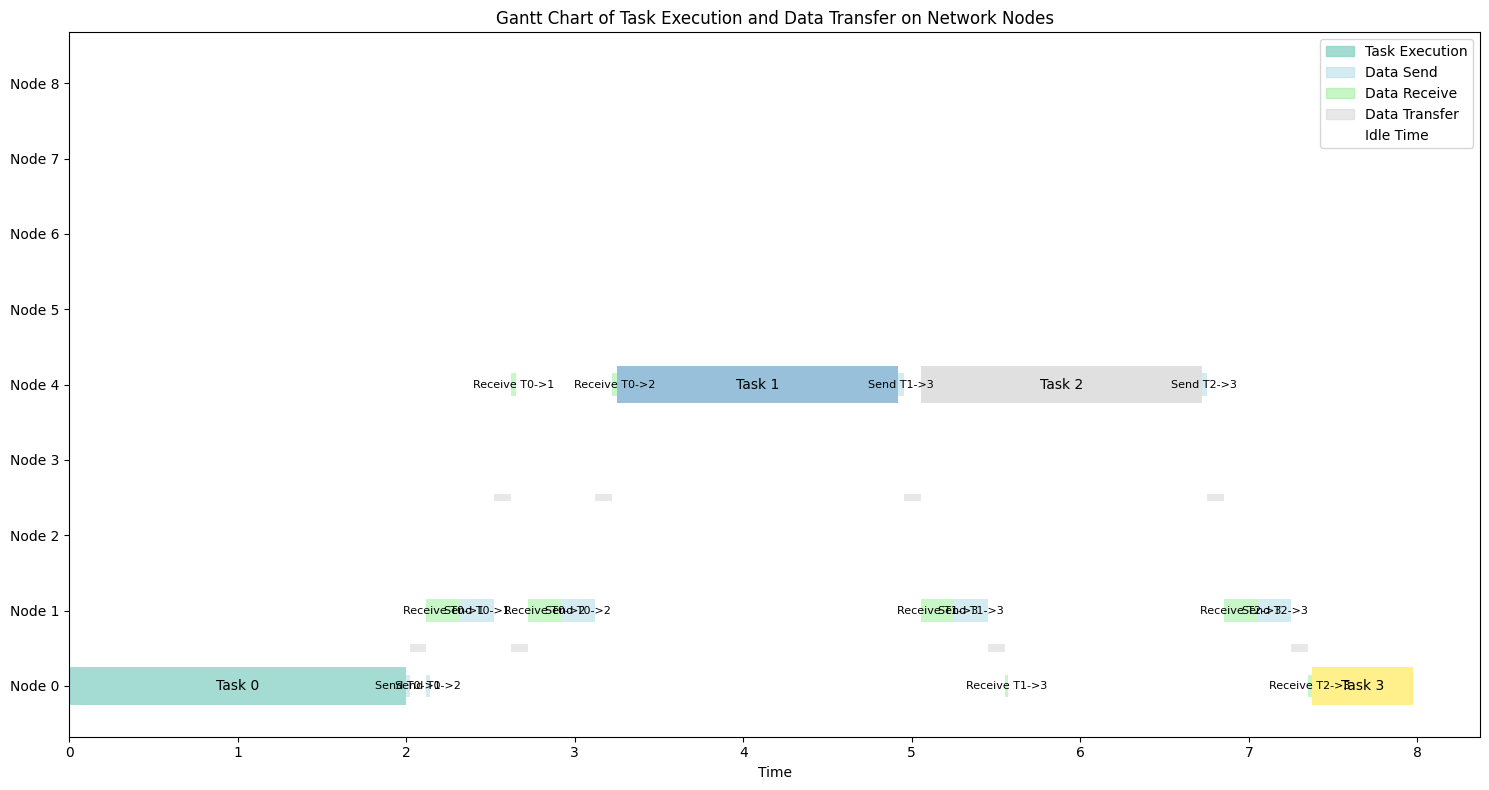

In [20]:
problem.scheduler.create_gantt_chart()

In [12]:
problem.evaluate([0,2,2,2,1,1,0,0,0,0,0,0,0])

inf

In [13]:
status(tuple([0,8,5,2,1,1,0,0,7,0,0,0,8]), problem)

{'Time': 22.50000000000002,
 'edge_hop': 33,
 'time_node': {0: 0.6500000000000019,
  1: 9.9,
  2: 2.3999999999999986,
  5: 2.1999999999999957,
  8: 2.700000000000003,
  4: 0.20000000000000995,
  7: 0.33333333333333215}}

In [14]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

from optiLib.optimizers import RandomSearchOptimizer

# Инициализация оптимизатора
optimizer = RandomSearchOptimizer(problem,iterations = 1000)

# Запуск оптимизации
best_solution, best_value = optimizer.optimize()

from optiLib.helpers import print_solution
print_solution(best_solution, best_value)

for i, item in enumerate(optimizer.history):
    optimizer.history[i]={**item, **network_status_calculation(tuple(item['vector']), problem)}

optimizer.save()

Optimizing: 100%|██████████| 1000/1000 [00:00<00:00, 6691.55it/s]


Лучшее решение: [0 0 5 0 3 3 4 3 0 4 0 0 3]
Значение целевой функции: 0.000140688298311217


TypeError: Optimizer.save() missing 1 required positional argument: 'experiment_number'

In [ ]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

from optiLib.optimizers import GreedyOptimizer

# Инициализация оптимизатора
optimizer = GreedyOptimizer(problem)

# Запуск оптимизации
best_solution, best_value = optimizer.optimize()

from optiLib.helpers import print_solution
print_solution(best_solution, best_value)

for i, item in enumerate(optimizer.history):
    optimizer.history[i]={**item, **network_status_calculation(tuple(item['vector']), problem)}

optimizer.save()